 <span style="font-size:19pt;">1)</span>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Column headers as a string separated by commas
headers_str = "poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat"

# Split the string to get the column names
column_names = headers_str.split(',')

# Replace 'your_file_path.data' with the actual path to your .data file
file_path = 'agaricus-lepiota.data'

# Read the .data file into a DataFrame
df = pd.read_table(file_path,sep=",", header=None, names= column_names)

print(df.shape)

print(df)

# Drop NaN values if any
df.dropna(inplace=True)
print(df.shape)

(8124, 23)
     poisonous cap-shape cap-surface cap-color bruises? odor gill-attachment  \
0            p         x           s         n        t    p               f   
1            e         x           s         y        t    a               f   
2            e         b           s         w        t    l               f   
3            p         x           y         w        t    p               f   
4            e         x           s         g        f    n               f   
...        ...       ...         ...       ...      ...  ...             ...   
8119         e         k           s         n        f    n               a   
8120         e         x           s         n        f    n               a   
8121         e         f           s         n        f    n               a   
8122         p         k           y         n        f    y               f   
8123         e         x           s         n        f    n               a   

     gill-spacing gill-size 

In [178]:
# Splitting the data into features (X) and target variable (y)
X = df.drop('poisonous', axis=1)
y = df['poisonous']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Perform one-hot encoding on the training and testing features
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

 <span style="font-size:19pt;">2)</span>

Decision Tree Classifier accuracy: 1.0000


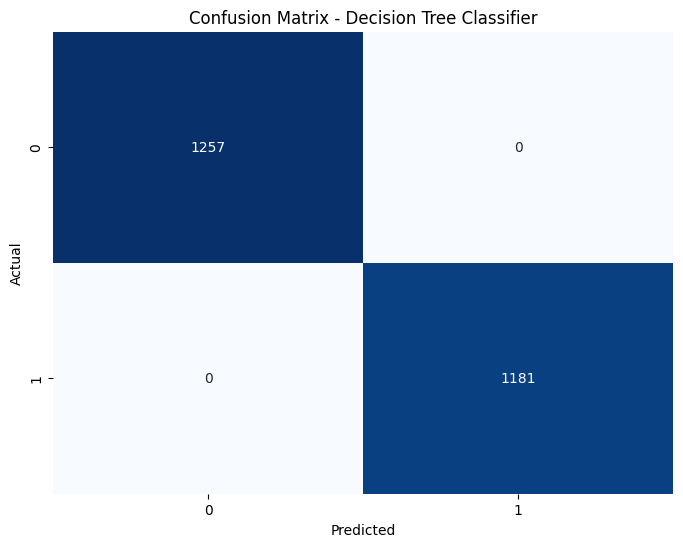

In [179]:
# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_encoded, y_train)

# Make predictions
y_pred = clf.predict(X_test_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Classifier accuracy: {accuracy:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

 <span style="font-size:19pt;">3)</span>

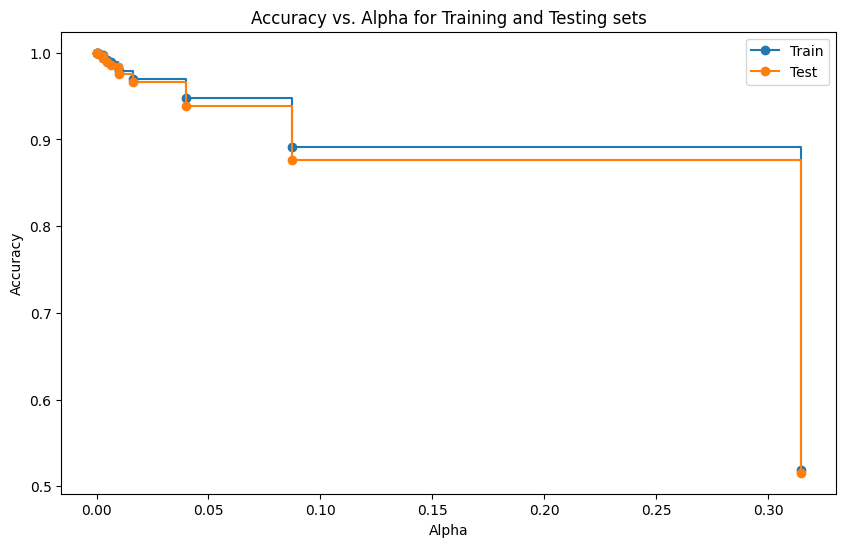

Decision Tree Classifier accuracy after pruning: 1.0000


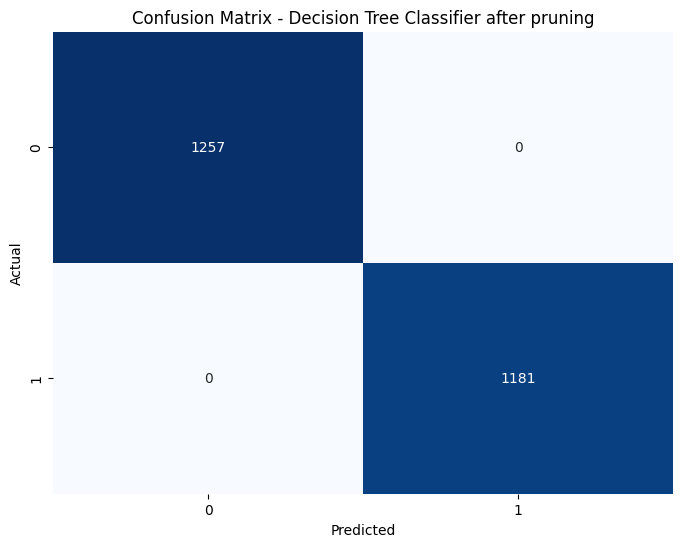

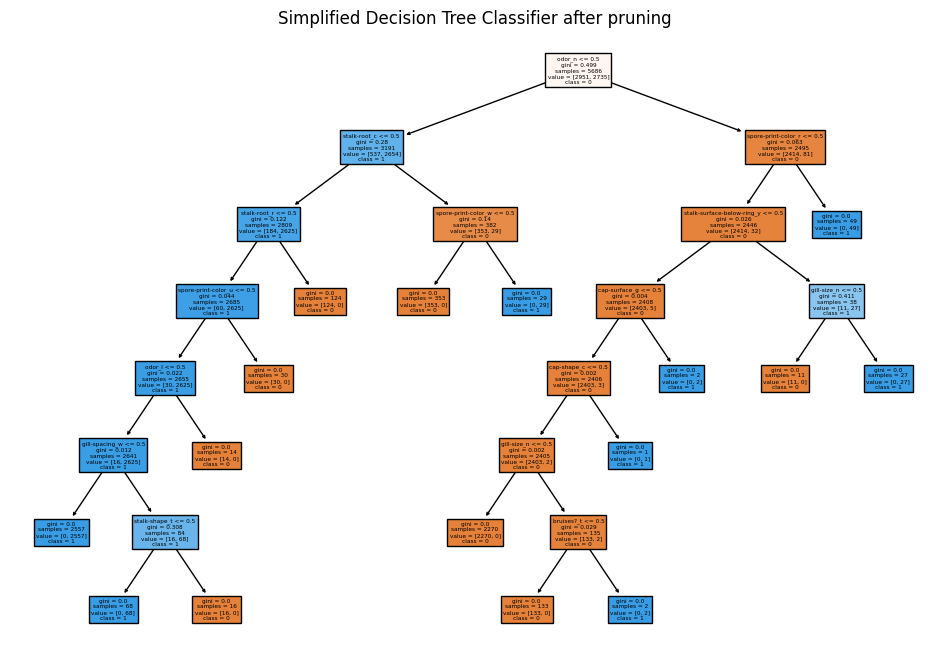

In [180]:
# # Initialize and train the Decision Tree Classifier with cost-complexity pruning
# clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0)  # Initialize with no pruning
# clf.fit(X_train_encoded, y_train)

# Cost-complexity pruning path
path = clf.cost_complexity_pruning_path(X_train_encoded, y_train)
alphas = path['ccp_alphas']

# Iterate over alphas to find the best one
clfs = []
for alpha in alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train_encoded, y_train)
    clfs.append(clf)

# Calculate accuracies for each alpha
train_scores = [clf.score(X_train_encoded, y_train) for clf in clfs]
test_scores = [clf.score(X_test_encoded, y_test) for clf in clfs]

# Plot the accuracies vs. alphas
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_scores, marker='o', label='Train', drawstyle="steps-post")
plt.plot(alphas, test_scores, marker='o', label='Test', drawstyle="steps-post")
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha for Training and Testing sets')
plt.legend()
plt.show()

# Choose the best alpha with the highest test accuracy
best_alpha = alphas[test_scores.index(max(test_scores))]

# Re-train the model with the best alpha
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf.fit(X_train_encoded, y_train)

# Make predictions
y_pred = clf.predict(X_test_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Classifier accuracy after pruning: {accuracy:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier after pruning')
plt.show()

# Plot the simplified tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X_train_encoded.columns, class_names=["0", "1"])
plt.title('Simplified Decision Tree Classifier after pruning')
plt.show()

What is intuitive is that we are using the gini index to evaluate when a node should be turned into a leaf which means that we have found a value adequate for the classification. What is not intuative is some of the values that represent classes sometimes go out of the range [0,1], which should not happen. 
Odor and color seems also to be very important feature in determining if mushroom is edible.
The accuracy is still 100% after cost complexity pruning.

 <span style="font-size:19pt;">4)</span>

XGBoost Classifier Accuracy: 1.0


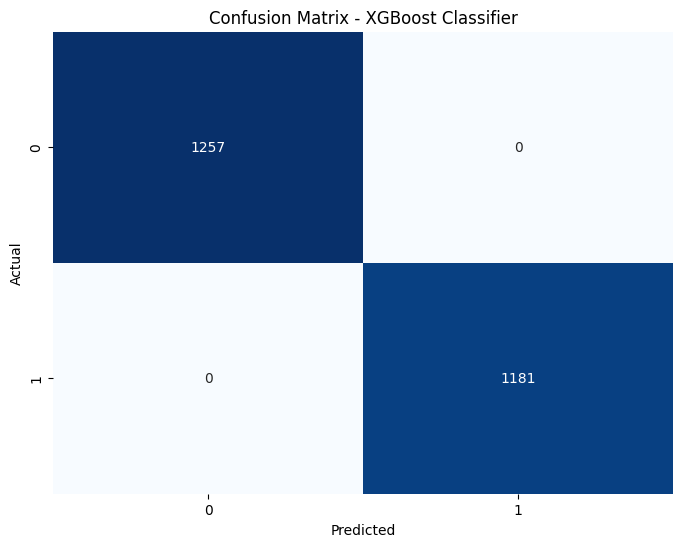

In [181]:
# Perform one-hot encoding on the training and testing features
y_train_encoded = pd.get_dummies(y_train, drop_first=True)
y_test_encoded = pd.get_dummies(y_test, drop_first=True)

# create XGBoost classifier
xgb = XGBClassifier()

# preset hyper parameters fine tuning to find best combination
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# start Hyper parameters fine tuning
xgb_grid = GridSearchCV(xgb, param_grid=params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train_encoded, y_train_encoded)

# record best combination of hyper parameters
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_encoded)
# evaluate performance of classification
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Classifier Accuracy:", accuracy_xgb)

# Print confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()


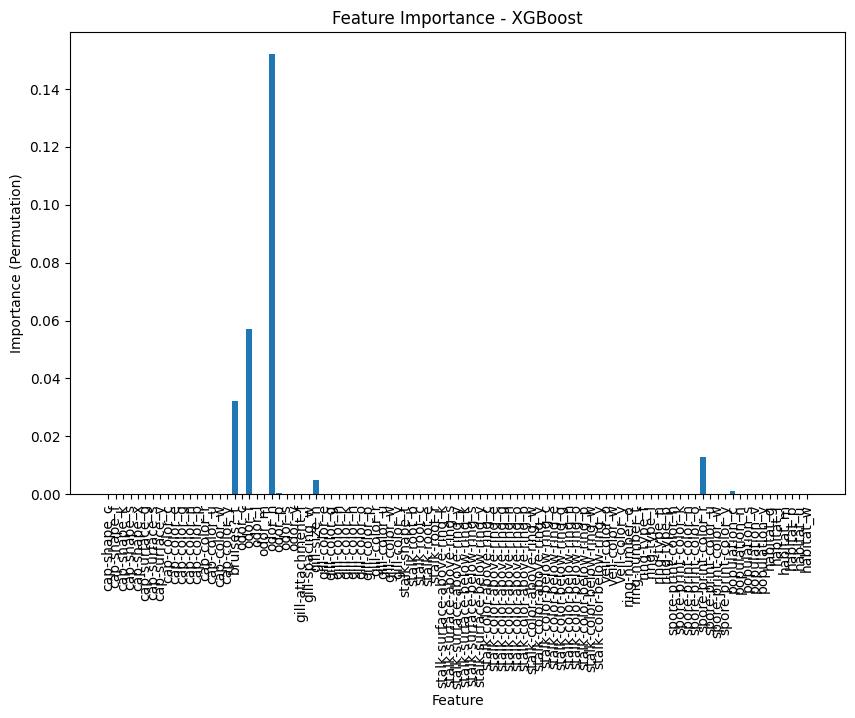

In [182]:
# Compute permutation importances for XGBoost
result = permutation_importance(xgb_best, X_test_encoded, y_test_encoded, n_repeats=10, random_state=42)
xgb_importances = result.importances_mean

# Plot feature importances for XGBoost
plt.figure(figsize=(10, 6))
plt.bar(X_train_encoded.columns, xgb_importances)
plt.xlabel('Feature')
plt.ylabel('Importance (Permutation)')
plt.title('Feature Importance - XGBoost')
plt.xticks(rotation=90)
plt.show()